In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley.kriging import KrigingIndices, janon_estimator, compute_indice, compute_indices, create_df_from_gp_indices, create_df_from_indices
from shapley.tests.test_functions import ishigami, ot_ishigami, ishigami_true_indices
from shapley.plots import set_style_paper, violin_plot_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

In [2]:
dim = 3
model = ishigami
ot_model = ot.PythonFunction(dim, 1, ot_ishigami)
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)
ot.RandomGenerator.SetSeed(0)

## Sobol indices with MC

MC var: [ 0.11168427  0.10532901  0.10915613]
Kriging var: [ 0.14612329  0.13578928  0.13856956]


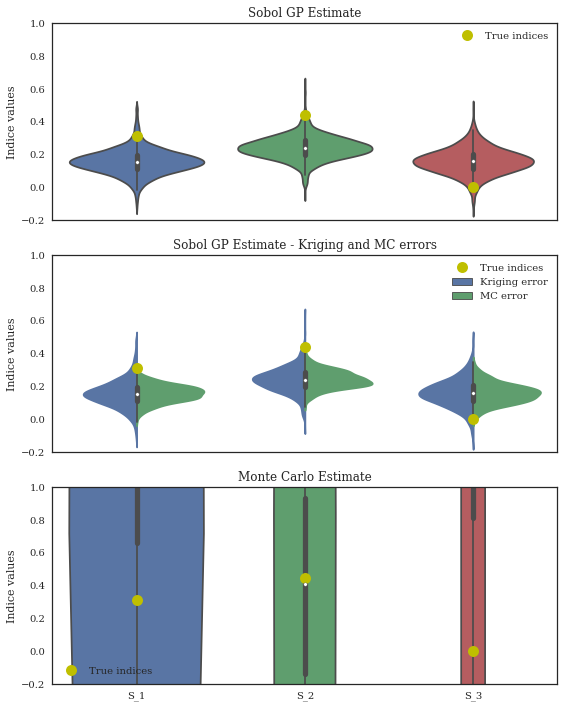

In [8]:
max_budgets = [50, 100, 200, 500]
n_samples_gp = [50, 100, 200, 500, 1000, 2000]
n_boot = 1000
n_realization_gp = 500
ylim = [-.2, 1.]

for n_sample_gp in max_budgets:
    for max_budget in max_budgets:
        n_sample = int(max_budget/(2*dim))
        input_sample_1 = np.asarray(input_distribution.getSample(n_sample))
        input_sample_2 = np.asarray(input_distribution.getSample(n_sample))
        first_indices_mc = compute_indices(model, input_sample_1, input_sample_2, n_boot=n_boot)

        kriging = KrigingIndices(ot_model, input_distribution)
        kriging.build_model(n_sample_kriging=max_budget)

        first_indices_gp = kriging.compute_indices(n_sample=n_sample_gp, n_realization=n_realization_gp, n_boot=n_boot)

        var_MC = first_indices_gp.std(axis=2).mean(axis=1)
        var_kriging = first_indices_gp.std(axis=1).mean(axis=1)
        print('MC var: {0}\nKriging var: {1}'.format(var_MC, var_kriging))

        df_indices_mc = create_df_from_indices(first_indices_mc)
        df_indices_gp = create_df_from_gp_indices(first_indices_gp)

        fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 10))

        ax = axes[0]
        sns.violinplot(x='Variables', y='Indice values', data=df_indices_gp, ax=ax, gridsize=500)
        ax.set_xlabel('')
        ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
        ax.set_title('Sobol GP Estimate')
        ax.legend(loc=0)
        ax.set_ylim(ylim)

        ax = axes[1]
        sns.violinplot(x='Variables', y='Indice values', data=df_indices_gp, hue='Error', ax=ax, split=True, gridsize=500)
        ax.set_xlabel('')
        ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
        ax.set_title('Sobol GP Estimate - Kriging and MC errors')
        ax.legend(loc=0)
        ax.set_ylim(ylim)

        ax = axes[2]
        sns.violinplot(x='Variables', y='Indice values', data=df_indices_mc, ax=ax, split=True, gridsize=500)
        ax.set_xlabel('')
        ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
        ax.set_title('Monte Carlo Estimate')
        ax.legend(loc=0)
        ax.set_ylim(ylim)

        fig.tight_layout()
        fig.savefig('output/ishigami_sobolGP_MC_n_%d_Nz_%d_m_%d_B_%d.pdf' % (max_budgets, n_realization_gp, n_sample_gp, n_boot))
        fig.savefig('output/ishigami_sobolGP_MC_n_%d_Nz_%d_m_%d_B_%d.png' % (max_budgets, n_realization_gp, n_sample_gp, n_boot))